In [1]:
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import decode_predictions

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import decode_predictions

In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# VGG16

In [4]:
from keras.applications.vgg16 import VGG16
model = VGG16()

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [7]:
plt.figure(figsize = (15, 15))

def get_image(image_path, image_size=(224, 224)):
    # load an image from file
    loaded_image = load_img(image_path, target_size=image_size)

    # convert the image pixels to a numpy array
    image_array = img_to_array(loaded_image)

    # reshape data for the model
    reshaped_image = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))
    return reshaped_image

def make_prediction(shaped_image, model):
    preds = model.predict(shaped_image)
    return preds
    
def get_class_activation_map(model, preds, reshaped_image, layer_name, hif=0.8, prediction_pos=0):
    sorted_preds = np.argsort(preds, axis=1)[0][::-1] #descending order
    output = model.output[:, sorted_preds[prediction_pos]]

    #Get the 512 input weights to the softmax.
    last_conv_index = -1

    class_weights = model.layers[last_conv_index].get_weights()[0]
    final_conv_layer = get_output_layer(model, layer_name)
    grads = K.gradients(output, final_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # give reshape_image as input, pooled_grads, and output of final_conv_layer
    iterate = K.function([model.layers[0].input], [pooled_grads, final_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([reshaped_image])
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    image_array = reshaped_image[0]
    print('image shape: {}'.format(image_array.shape))
    heatmap = cv2.resize(heatmap, (image_array.shape[1], image_array.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    intensified_heatmap = (heatmap*hif).astype(np.uint8)
    return intensified_heatmap

In [8]:
reshaped_image = get_image('./pandas-for-data-analysis.jpg')
preds = make_prediction(reshaped_image, model)

In [9]:
predictions = pd.DataFrame(decode_predictions(preds, top=100)[0],columns=['col1','category','probability']).iloc[:,1:]
print("PREDICTIONS: \n{}".format(predictions))
print('PREDICTION:',predictions.loc[5,'category'])

PREDICTIONS: 
                   category  probability
0               giant_panda     0.650484
1                    weasel     0.185239
2                    badger     0.107090
3                   polecat     0.013873
4       black-footed_ferret     0.011294
5                     skunk     0.010028
6              lesser_panda     0.007342
7                      mink     0.003557
8                Arctic_fox     0.002519
9        Bedlington_terrier     0.001984
10                    indri     0.001797
11           Madagascar_cat     0.001468
12                    goose     0.000566
13                 ice_bear     0.000335
14                  wallaby     0.000223
15                   guenon     0.000193
16                  colobus     0.000178
17                    llama     0.000166
18                 mongoose     0.000151
19                      ram     0.000139
20                   marmot     0.000092
21               sloth_bear     0.000091
22  wire-haired_fox_terrier     0.000078
23

image shape: (224, 224, 3)


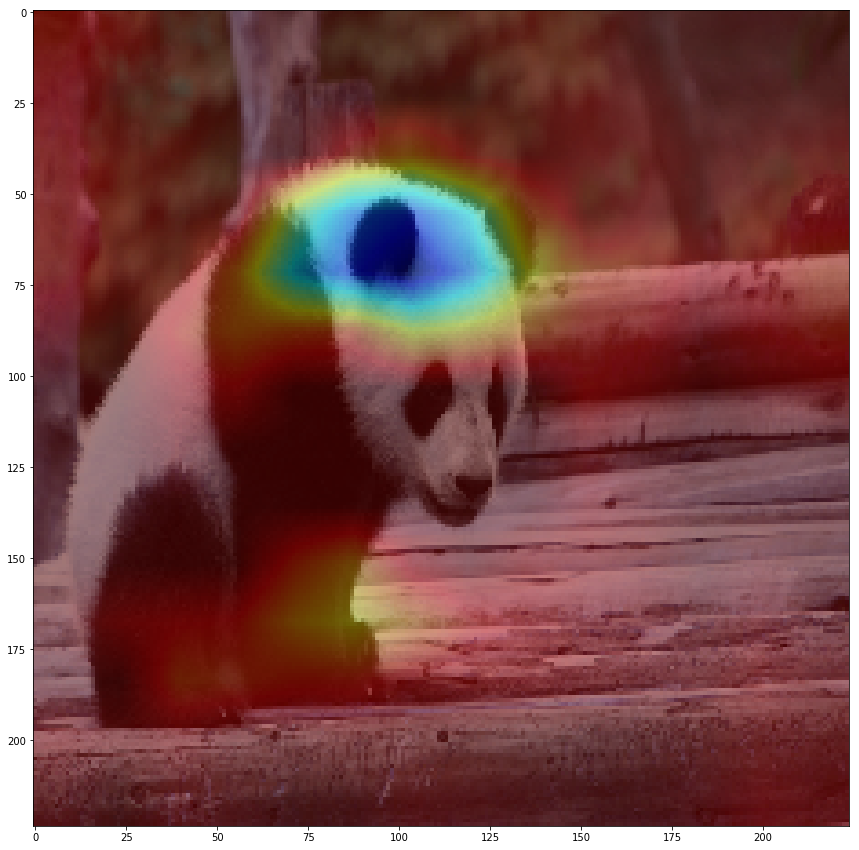

In [32]:
heatmap_image = get_class_activation_map(model, preds, reshaped_image, "block5_conv3", prediction_pos=1)
cv2_image = cv2.resize(cv2.imread('./pandas-for-data-analysis.jpg'), (224, 224))
cam_image = cv2.addWeighted(cv2_image, 0.5, heatmap_image, 0.5, 0)
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(cam_img)

image shape: (224, 224, 3)


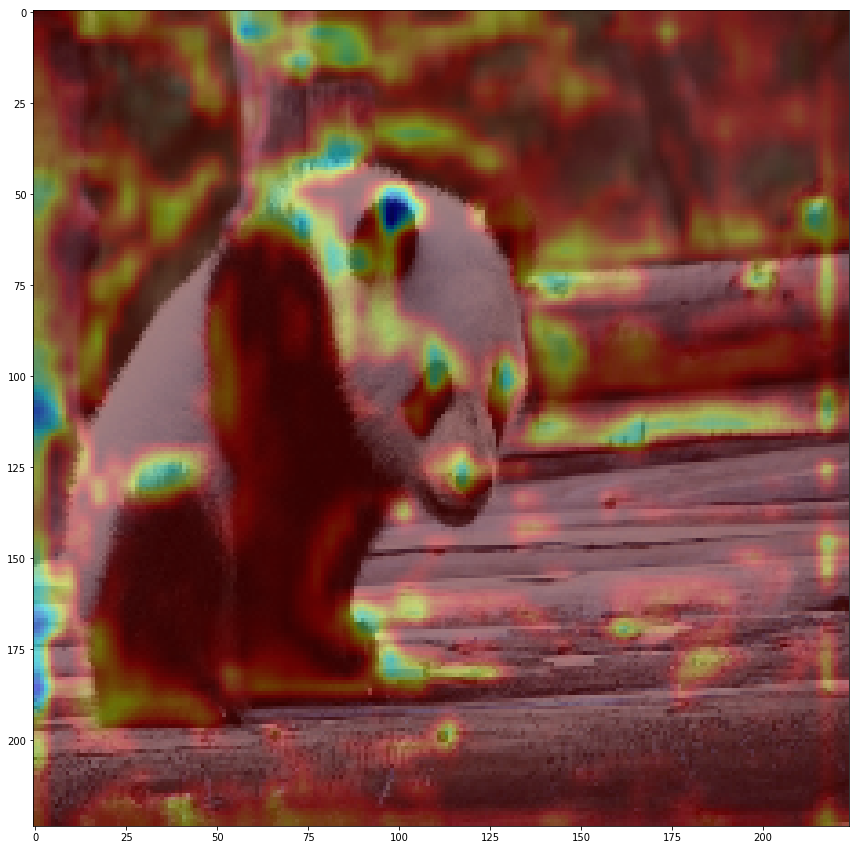

In [11]:
heatmap_image = get_class_activation_map(model, preds, reshaped_image, "block3_conv3", prediction_pos=5)
cv2_image = cv2.resize(cv2.imread('./pandas-for-data-analysis.jpg'), (224, 224))
cam_image = cv2.addWeighted(cv2_image, 0.5, heatmap_image, 0.5, 0)
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(cam_image)

In [12]:
import cv2
cv2.imwrite("cam_panda_conv3.png", cam_image)

True